# Données nécessaire
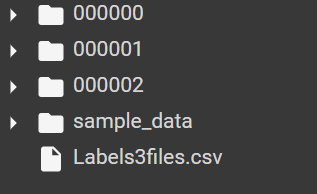

# Impoartation des packages


In [ ]:
import pandas as pd # Pour le dataframe
import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt # Pour la visualisation

from PIL import Image

import librosa # Pour l'extraction des features et la lecture des fichiers wav
import librosa.display # Pour récupérer les spectrogrammes des audio
import librosa.feature

import os # C'est ce qui va nous permettre d'itérer sur les fichiers de l'environnement de travail

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV # Split de dataset et optimisation des hyperparamètres
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.ensemble import GradientBoostingClassifier # XGBoost
from sklearn.neighbors import KNeighborsClassifier # k-NN
from sklearn.svm import SVC # SVM
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report # Métriques pour la mesure de performances
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf # Pour le reseau de neurones simple et pour le CNN

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

In [ ]:
#Pour la features Pitch
import statsmodels.api as sm
from scipy.signal import find_peaks

# Import de la BDD 

In [ ]:
#récupération de nos sons 
from glob import glob
audio_files = []
data_dir = '.'

audio_files1 = glob('/content/000000/*.wav')
for i in audio_files1 : 
  audio_files.append(i)

audio_files2 = glob('/content/000001/*.wav')
for i in audio_files2 : 
  audio_files.append(i)

audio_files3 = glob('/content/000002/*.wav')
for i in audio_files3 : 
  audio_files.append(i)



len(audio_files)



99

In [ ]:
#récupération de nos labels 
dataNote = pd.read_csv("Labels3files.csv",sep=";")
dataNote = dataNote[0:99]
dataNote

,Moyenne,Mediane
0,"1,143",1
1,"0,000",0
2,"0,857",2
3,"0,714",1
4,"1,571",2
...,...,...
94,"0,714",1
95,"-1,000",-1
96,"-0,429",-1
97,"2,000",2


In [ ]:
#Récupération des noms de nos sons triés 
audio_name=[]
for audio in audio_files:
   audio_name.append((str(audio)[16:-4]))

audio_name.sort()


In [ ]:
from scipy.sparse import data
#Rajout des noms dans notre dataframe
dataNote = dataNote.assign(Sons=audio_name)
dataNote

,Moyenne,Mediane,Sons
0,"1,143",1,000000
1,"0,000",0,000057
2,"0,857",2,000094
3,"0,714",1,000110
4,"1,571",2,000135
...,...,...,...
94,"0,714",1,003887
95,"-1,000",-1,003943
96,"-0,429",-1,003982
97,"2,000",2,003993


In [ ]:
data, sampling_frequency = librosa.load(audio_files[6])
sampling_frequency

#Fréquence identique pour tout les sons 

22050

In [ ]:
data, sampling_frequency = librosa.load(audio_files[0])
data

array([-1.4699094e-06,  2.1696096e-08,  1.8474466e-06, ...,
        2.9880682e-04,  2.4165331e-04, -1.7150672e-04], dtype=float32)

In [ ]:
#récupére les vecteur de chaque son qu'on utilisera dans nos features plus tard 
#Important d'avoir les noms des sons afin de les triés plus tard 
VectAudio = {'audio_name':[],'val_audio':[]}
for audio in range(len(audio_files)):
    data, sampling_frequency = librosa.load(audio_files[audio])
    VectAudio['val_audio'].append(data)
    VectAudio['audio_name'].append((str(audio_files[audio])[16:-4]))

In [ ]:
VectAudio['val_audio']

[array([-1.4699094e-06,  2.1696096e-08,  1.8474466e-06, ...,
         2.9880682e-04,  2.4165331e-04, -1.7150672e-04], dtype=float32),
 array([ 7.7471037e-07, -8.9088093e-07,  1.0320582e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
 array([ 1.7523774e-07, -1.9511839e-07,  2.0388620e-07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
 array([-5.6795375e-07,  6.7414572e-07, -1.2854692e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
 array([ 6.0546540e-08, -5.7307762e-08,  4.3571955e-08, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
 array([-1.12104972e-05, -1.18242264e-04, -2.67884752e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00], dtype=float32),
 array([-5.29175793e-07,  3.62889750e-07, -3.91621825e-07, ...,
         1.09088486e-02,  1.09031936e-02,  1.16431685e-02], dtype=float32),
 array([ 2.1139578e-10, -2.4216204e-10,  2.1237896

# Extraction des features 

In [ ]:
!pip install pydub
from pydub import AudioSegment
# Load files
audio_segment = AudioSegment.from_file(audio_files[0])
# Print attributes
print(f"Channels: {audio_segment.channels}")
print(f"Sample width: {audio_segment.sample_width}")
print(f"Frame rate (sample rate): {audio_segment.frame_rate}")
print(f"Frame width: {audio_segment.frame_width}")
print(f"Length (ms): {len(audio_segment)}")
print(f"Frame count: {audio_segment.frame_count()}")
print(f"Intensity: {audio_segment.dBFS}")

#On s'interressera seulement aux données Length (ms),Frame count,Intensity. Les autres sont identiques pour tous les sons 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Channels: 1
Sample width: 2
Frame rate (sample rate): 11025
Frame width: 2
Length (ms): 363
Frame count: 4000.0
Intensity: -22.346724864584306


In [ ]:
def features_segment(audio):
  # Load files
  audio_segment = AudioSegment.from_file(audio)

  Features_seg = []
  # Print attributes
  length = len(audio_segment)
  Features_seg.append(length)
  Frame_count = audio_segment.frame_count()
  Features_seg.append(Frame_count)
  intensity = audio_segment.dBFS
  Features_seg.append(intensity)

  return Features_seg



In [ ]:
Features_seg=[]
for audio in audio_files : 
  Features_seg.append(features_segment(audio))

#Features_seg

[Text(0.5, 1.0, 'log Power spectrogram')]

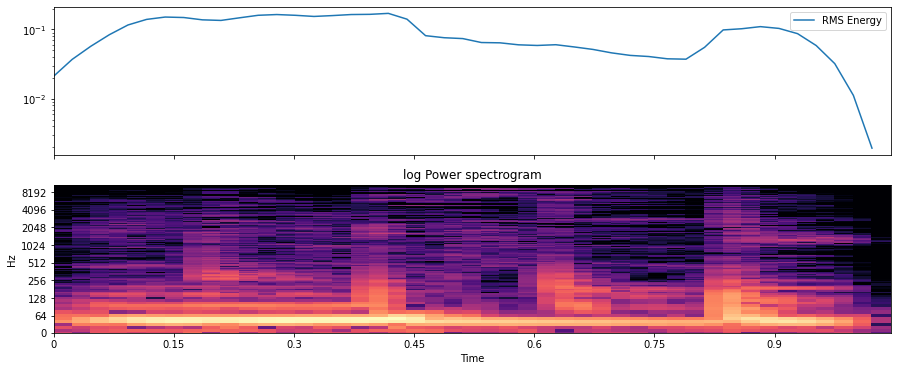

In [ ]:
y, sr = librosa.load(audio_files[5])
# Get RMS value from each frame's magnitude value
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)
# Plot the RMS energy
fig, ax = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

In [ ]:
def audio_pipeline(audio):


  features = []

  # Calcul du ZCR

  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC

  mfcc = librosa.feature.mfcc(audio)

  for x in mfcc:
    features.append(np.mean(x))

  #Pitch feature 
  # T = 1/sampling_frequency # Sampling period
  # N = len(audio) # Signal length in samples
  # t = N / sampling_frequency # Signal length in seconds
  # auto = sm.tsa.acf(audio, nlags=2000)
  # peaks = find_peaks(auto)[0] # Find peaks of the autocorrelation
  # lag = peaks[0] # Choose the first peak as our pitch component lag
  # pitch = sampling_frequency / lag # Transform lag into frequency
  # features.append(pitch)

  #Root-mean-square (RMS)
  # RMS Features 
  S, phase = librosa.magphase(librosa.stft(audio))
  rms = librosa.feature.rms(S=S)
  rms_mean = np.mean(rms)
  features.append(rms_mean)

  return features

Après essaie de la feature Pitch, on a fait le choix de la supprimer car il était compliqué de l'implémenter.

In [ ]:
column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20','rms']
len(column_names)


24

In [ ]:
Features = []
for audio in VectAudio['val_audio']:
  #print(audio)
  Features.append(audio_pipeline(audio))

[-1.4699094e-06  2.1696096e-08  1.8474466e-06 ...  2.9880682e-04
  2.4165331e-04 -1.7150672e-04]
[ 7.7471037e-07 -8.9088093e-07  1.0320582e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[ 1.7523774e-07 -1.9511839e-07  2.0388620e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[-5.6795375e-07  6.7414572e-07 -1.2854692e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[ 6.0546540e-08 -5.7307762e-08  4.3571955e-08 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[-1.12104972e-05 -1.18242264e-04 -2.67884752e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-5.29175793e-07  3.62889750e-07 -3.91621825e-07 ...  1.09088486e-02
  1.09031936e-02  1.16431685e-02]
[ 2.1139578e-10 -2.4216204e-10  2.1237896e-10 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[-3.0113654e-07  3.9997940e-07 -4.9141858e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[ 3.5371067e-06 -2.9425704e-05 -7.0866983e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[-6.7691094e-06 -7

KeyboardInterrupt: ignored

In [ ]:
len(Features)

299

In [ ]:
df = pd.DataFrame(Features,columns = column_names)
df

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,rms
0,3165,2477.135427,4805.660088,-172.735260,86.392502,11.633582,34.378700,4.480689,5.732243,-8.353706,...,1.331612,-10.819526,2.815391,-3.499773,-0.395267,-22.498695,4.526295,-14.678613,-6.172539,0.065944
1,1526,1737.128177,3609.443359,-153.346512,115.708527,2.977004,36.350166,8.057545,-4.032084,-13.829380,...,-3.410464,-14.989627,5.179573,-5.925041,-3.220202,-12.988390,-8.534726,-6.795821,-5.658012,0.085395
2,2995,2958.610392,6021.640625,-136.034760,63.956081,-0.648479,43.749924,-21.601589,30.571634,-7.896911,...,13.719024,0.215238,11.098707,0.140795,9.920561,1.095415,9.994039,-0.924463,7.847404,0.060579
3,1386,197.291374,397.212916,-516.169373,19.366339,-6.328653,8.355364,-1.011979,0.097239,-0.523524,...,-0.795540,-1.181019,-0.438878,-2.067446,-0.918984,-1.329113,-1.032530,-0.649856,-0.305876,0.011213
4,276,1219.778345,3140.976562,-294.302460,80.183243,11.482393,38.430950,36.499798,38.173042,13.142433,...,10.490986,5.623020,17.413660,9.902650,10.005630,7.502749,10.248769,-2.604941,3.015542,0.091751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,246,450.358149,568.877180,-404.641998,102.547058,74.996597,54.611282,36.881081,49.741909,20.779732,...,13.726839,5.949011,2.849520,10.092090,0.412068,-1.310487,7.334092,-1.405323,-2.161498,0.098114
295,2176,1863.002653,3726.440430,-92.931282,118.364159,-20.518280,30.778679,8.031467,10.215549,-1.479570,...,-2.953633,-15.455791,5.156332,-8.699983,5.253343,-1.073447,7.586294,-5.845106,1.645245,0.093422
296,2574,2221.614807,4239.887695,-180.182602,98.308716,7.455194,35.713837,13.993644,2.339120,-13.143981,...,-9.214528,-16.855747,2.381374,-8.020084,2.917951,-11.195682,-1.373311,-5.556245,-3.076923,0.055559
297,4599,2664.902914,5302.431641,-491.303345,14.967323,-21.948437,28.441587,-12.006804,1.493010,-5.544097,...,-8.648107,3.574912,-0.122251,-14.492970,-1.353842,0.806260,1.345043,-9.112428,3.974561,0.022221


In [ ]:
column_names_seg = ['Length','Frame count','Intensity']

In [ ]:
df1 = pd.DataFrame(Features_seg,columns = column_names_seg)
print(audio_files[0])
df1

/content/000000/000110.wav


,Length,Frame count,Intensity
0,975,43008.0,-18.144899
1,1022,45056.0,-16.118512
2,1022,45056.0,-18.283012
3,8019,353616.0,-25.359353
4,1022,45056.0,-15.278798
...,...,...,...
294,975,43008.0,-14.766264
295,1022,45056.0,-15.625808
296,1022,45056.0,-19.427638
297,1022,45056.0,-23.741407


In [ ]:
df = pd.concat([df, df1], axis=1)
df

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,rms,Length,Frame count,Intensity
0,3165,2477.135427,4805.660088,-172.735260,86.392502,11.633582,34.378700,4.480689,5.732243,-8.353706,...,-3.499773,-0.395267,-22.498695,4.526295,-14.678613,-6.172539,0.065944,975,43008.0,-18.144899
1,1526,1737.128177,3609.443359,-153.346512,115.708527,2.977004,36.350166,8.057545,-4.032084,-13.829380,...,-5.925041,-3.220202,-12.988390,-8.534726,-6.795821,-5.658012,0.085395,1022,45056.0,-16.118512
2,2995,2958.610392,6021.640625,-136.034760,63.956081,-0.648479,43.749924,-21.601589,30.571634,-7.896911,...,0.140795,9.920561,1.095415,9.994039,-0.924463,7.847404,0.060579,1022,45056.0,-18.283012
3,1386,197.291374,397.212916,-516.169373,19.366339,-6.328653,8.355364,-1.011979,0.097239,-0.523524,...,-2.067446,-0.918984,-1.329113,-1.032530,-0.649856,-0.305876,0.011213,8019,353616.0,-25.359353
4,276,1219.778345,3140.976562,-294.302460,80.183243,11.482393,38.430950,36.499798,38.173042,13.142433,...,9.902650,10.005630,7.502749,10.248769,-2.604941,3.015542,0.091751,1022,45056.0,-15.278798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,246,450.358149,568.877180,-404.641998,102.547058,74.996597,54.611282,36.881081,49.741909,20.779732,...,10.092090,0.412068,-1.310487,7.334092,-1.405323,-2.161498,0.098114,975,43008.0,-14.766264
295,2176,1863.002653,3726.440430,-92.931282,118.364159,-20.518280,30.778679,8.031467,10.215549,-1.479570,...,-8.699983,5.253343,-1.073447,7.586294,-5.845106,1.645245,0.093422,1022,45056.0,-15.625808
296,2574,2221.614807,4239.887695,-180.182602,98.308716,7.455194,35.713837,13.993644,2.339120,-13.143981,...,-8.020084,2.917951,-11.195682,-1.373311,-5.556245,-3.076923,0.055559,1022,45056.0,-19.427638
297,4599,2664.902914,5302.431641,-491.303345,14.967323,-21.948437,28.441587,-12.006804,1.493010,-5.544097,...,-14.492970,-1.353842,0.806260,1.345043,-9.112428,3.974561,0.022221,1022,45056.0,-23.741407


In [ ]:
df = df.assign(name=VectAudio['audio_name'])
df.head()

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,rms,Length,Frame count,Intensity,name
0,3165,2477.135427,4805.660088,-172.735260,86.392502,11.633582,34.378700,4.480689,5.732243,-8.353706,...,-0.395267,-22.498695,4.526295,-14.678613,-6.172539,0.065944,975,43008.0,-18.144899,000110
1,1526,1737.128177,3609.443359,-153.346512,115.708527,2.977004,36.350166,8.057545,-4.032084,-13.829380,...,-3.220202,-12.988390,-8.534726,-6.795821,-5.658012,0.085395,1022,45056.0,-16.118512,003520
2,2995,2958.610392,6021.640625,-136.034760,63.956081,-0.648479,43.749924,-21.601589,30.571634,-7.896911,...,9.920561,1.095415,9.994039,-0.924463,7.847404,0.060579,1022,45056.0,-18.283012,002092
3,1386,197.291374,397.212916,-516.169373,19.366339,-6.328653,8.355364,-1.011979,0.097239,-0.523524,...,-0.918984,-1.329113,-1.032530,-0.649856,-0.305876,0.011213,8019,353616.0,-25.359353,003507
4,276,1219.778345,3140.976562,-294.302460,80.183243,11.482393,38.430950,36.499798,38.173042,13.142433,...,10.005630,7.502749,10.248769,-2.604941,3.015542,0.091751,1022,45056.0,-15.278798,003835


In [ ]:
#On va rassembler nos deux dataframes df et DataNote

#On trie df de la même façon que dataNote pour les noms des sons
df = df.sort_values(by = 'name')
df.reset_index(inplace=True)


In [ ]:
#On rajoute les colonne Mediane 
df = df.assign(Mediane=dataNote['Mediane'])
df.head()

,index,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc17,mfcc18,mfcc19,mfcc20,rms,Length,Frame count,Intensity,name,Mediane
0,39,3680,2934.779141,5564.658203,-253.011963,54.133663,-39.310814,30.840712,-13.413972,26.794708,...,-0.211988,15.796876,-2.705430,8.065567,0.017894,1022,45056.0,-27.349292,000000,1
1,69,4320,2560.556494,4268.837891,-221.466385,102.539345,31.919659,11.077250,-7.896761,7.074344,...,-15.156174,3.702475,-11.576396,-4.254362,0.049615,1022,45056.0,-20.252266,000057,0
2,42,2768,2620.299232,5301.925304,-216.400116,67.443993,6.657395,34.802467,6.640349,-30.890245,...,-13.072521,-10.907011,-15.969991,0.114824,0.060278,975,43008.0,-18.647291,000094,2
3,0,3165,2477.135427,4805.660088,-172.735260,86.392502,11.633582,34.378700,4.480689,5.732243,...,-22.498695,4.526295,-14.678613,-6.172539,0.065944,975,43008.0,-18.144899,000110,1
4,87,1996,162.351351,317.843823,-584.722290,15.275802,-7.362199,6.804171,-2.051059,0.132979,...,-0.900335,-0.692796,-0.419166,-0.113317,0.007822,10900,480680.0,-27.232701,000135,2


# Evaluation des qualités des donées 

## Corrélation 

Il peut être intéressant de retirer des variables qui sont corrélées pour réduire le nombre de features

Text(0.5, -0.15, 'Matrice de corrélation')

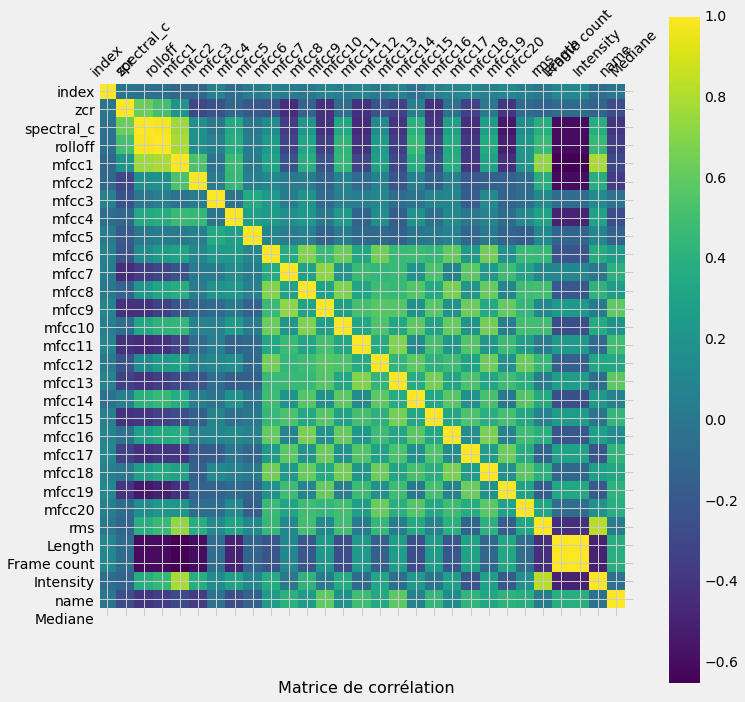

In [ ]:
# Corrélation 


f = plt.figure(figsize=(12, 12))
#ax = plt.gca()
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
#ax.tick_params(axis="x", bottom=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Matrice de corrélation', fontsize=16, y=-0.15)

On peut voir qu'il y a une forte corrélation entre Roll Off et MFCC1, également entre les features 'Frame count' et 'length'

## Variance 

Pour le calcul de variances, on fixe un seuil en dessous du quel on élimine la variable. 

In [ ]:
# Variance 

selector = VarianceThreshold(threshold=(0.2))
selected_features = selector.fit_transform(df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                                              'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                                              'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                                              'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20','Mediane']])

var = pd.DataFrame(selected_features)
var.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,3680.0,2934.779141,5564.658203,-253.011963,54.133663,-39.310814,30.840712,-13.413972,26.794708,-7.773553,...,17.142742,-0.430651,13.617473,-5.770791,13.759635,-0.211988,15.796876,-2.705430,8.065567,1.0
1,4320.0,2560.556494,4268.837891,-221.466385,102.539345,31.919659,11.077250,-7.896761,7.074344,-6.077971,...,1.679322,-12.042150,5.560037,-9.532566,0.708996,-15.156174,3.702475,-11.576396,-4.254362,0.0
2,2768.0,2620.299232,5301.925304,-216.400116,67.443993,6.657395,34.802467,6.640349,-30.890245,-31.068678,...,4.344543,-22.465471,-0.090734,-22.911768,-9.409763,-13.072521,-10.907011,-15.969991,0.114824,2.0
3,3165.0,2477.135427,4805.660088,-172.735260,86.392502,11.633582,34.378700,4.480689,5.732243,-8.353706,...,1.331612,-10.819526,2.815391,-3.499773,-0.395267,-22.498695,4.526295,-14.678613,-6.172539,1.0
4,1996.0,162.351351,317.843823,-584.722290,15.275802,-7.362199,6.804171,-2.051059,0.132979,-0.816177,...,-0.800113,-0.884431,-0.200289,-1.482056,-0.395913,-0.900335,-0.692796,-0.419166,-0.113317,2.0


Toutes nos features ont des variances assez élevées pour être considérées dans l'étude.

## Répartitions des classes
Classes : -2 , -1 ,0 ,1 ,2 

In [ ]:
Classes = [-2,-1,0,1,2]

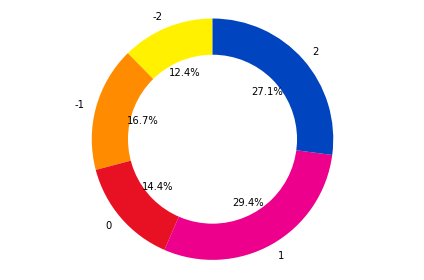

In [ ]:
y = df['Mediane']
values = np.unique(y,return_counts=True)[1]

labels = Classes
sizes = values

# Choix des couleurs

colors =['#fff100','#ff8c00','#e81123','#ec008c','#0044bf']
 
# Construction du diagramme et affichage des labels et des #fréquences en pourcentage

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

# Tracé du cercle au milieu

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Affichage du diagramme

ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [ ]:
## On va changer notre label à la place d'avoir 5 classes on en aura plus que 2 
 
df['Mediane']=[0if i<1 else 1 for i in df.Mediane]
df.head()

,index,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc17,mfcc18,mfcc19,mfcc20,rms,Length,Frame count,Intensity,name,Mediane
0,39,3680,2934.779141,5564.658203,-253.011963,54.133663,-39.310814,30.840712,-13.413972,26.794708,...,-0.211988,15.796876,-2.705430,8.065567,0.017894,1022,45056.0,-27.349292,000000,1
1,69,4320,2560.556494,4268.837891,-221.466385,102.539345,31.919659,11.077250,-7.896761,7.074344,...,-15.156174,3.702475,-11.576396,-4.254362,0.049615,1022,45056.0,-20.252266,000057,0
2,42,2768,2620.299232,5301.925304,-216.400116,67.443993,6.657395,34.802467,6.640349,-30.890245,...,-13.072521,-10.907011,-15.969991,0.114824,0.060278,975,43008.0,-18.647291,000094,1
3,0,3165,2477.135427,4805.660088,-172.735260,86.392502,11.633582,34.378700,4.480689,5.732243,...,-22.498695,4.526295,-14.678613,-6.172539,0.065944,975,43008.0,-18.144899,000110,1
4,87,1996,162.351351,317.843823,-584.722290,15.275802,-7.362199,6.804171,-2.051059,0.132979,...,-0.900335,-0.692796,-0.419166,-0.113317,0.007822,10900,480680.0,-27.232701,000135,1


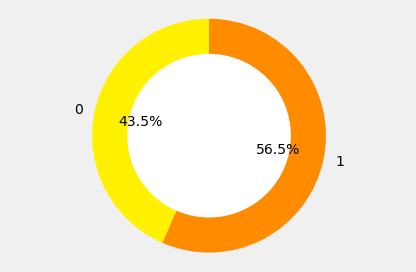

In [ ]:
New_classes = [0,1]
y = df['Mediane']
values = np.unique(y,return_counts=True)[1]

labels = New_classes
sizes = values

# Choix des couleurs

colors =['#fff100','#ff8c00','#e81123','#ec008c','#0044bf']
 
# Construction du diagramme et affichage des labels et des #fréquences en pourcentage

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

# Tracé du cercle au milieu

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Affichage du diagramme

ax1.axis('equal')  
plt.tight_layout()
plt.show()

# Entrainement de différents modèle 

 



## Constructions des ensembles d’entraînement

In [ ]:
column_selected = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20','rms','Length','Frame count','Intensity']

# split data into X and y
X = df[column_selected]
y = df['Mediane']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


## XGBOOST


Importance des features

Text(0.5, 1.0, 'Variable Importances')

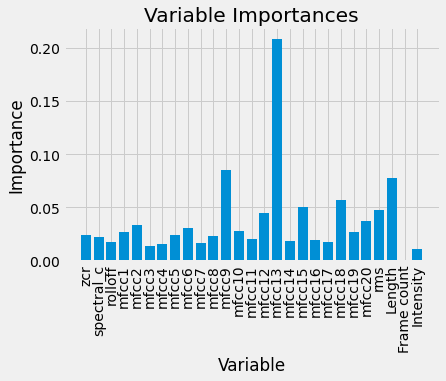

In [ ]:
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# feature importance
plt.style.use('fivethirtyeight')

importances = list(model.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, column_selected, rotation='vertical')

plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

In [ ]:
#Récupère les 10 meilleurs features 
a = sorted(importances)
Best_importances = a[-10:]
Index_best_features = []
best_features = []

for i in Best_importances :
  for j in range(len(importances)) : 
    if i == importances[j] :
      Index_best_features.append(j)

#Index_best_features

for i in Index_best_features : 
  best_features.append(column_selected[i])

best_features

['mfcc6',
 'mfcc2',
 'mfcc20',
 'mfcc12',
 'rms',
 'mfcc15',
 'mfcc18',
 'Length',
 'mfcc9',
 'mfcc13']

Entrainement du modèle 


In [ ]:
## Pour toutes les features 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# valeurs à prédire
labels = np.array(df['Mediane'])
# supprime les labels des données
features = df[column_selected]
# sauvegarde le nom de features
feature_list = list(features.columns)
# conversion en numpy array
features = np.array(features)

# séparer les données en training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 0)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (224, 27)
Training Labels Shape: (224,)
Testing Features Shape: (75, 27)
Testing Labels Shape: (75,)


In [ ]:
# Avec toutes les features 
#model = XGBClassifier(objective='multi:softprob', colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=3, max_depth=10, min_child_weight=1, n_estimators=300, subsample=0.8, random_state = 0)
model = XGBClassifier( colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10, min_child_weight=1, n_estimators=300, subsample=0.8, random_state = 0)

# fit the model with the training data
model.fit(train_features, train_labels)
 
# predict the target on the test dataset
predict_test = model.predict(test_features)
 
# Accuracy Score on test dataset
accuracy_test = accuracy_score(test_labels, predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)


accuracy_score on test dataset :  0.8133333333333334


In [ ]:
# Pour les 10 features les plus importantes 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# valeurs à prédire
labels = np.array(df['Mediane'])
# supprime les labels des données
features_10 = df[best_features]
# sauvegarde le nom de features
feature_list = list(features_10.columns)
# conversion en numpy array
features = np.array(features_10)

# séparer les données en training and testing sets
train_features_10, test_features_10, train_labels_10, test_labels_10 = train_test_split(features_10, labels, test_size = 0.25, random_state = 0)
print('Training Features Shape:', train_features_10.shape)
print('Training Labels Shape:', train_labels_10.shape)
print('Testing Features Shape:', test_features_10.shape)
print('Testing Labels Shape:', test_labels_10.shape)


sc = StandardScaler()
train_features_10 = sc.fit_transform(train_features_10)
test_features_10 = sc.transform(test_features_10)


Training Features Shape: (224, 10)
Training Labels Shape: (224,)
Testing Features Shape: (75, 10)
Testing Labels Shape: (75,)


In [ ]:
## Avec les 10 meilleurs features 
#model = XGBClassifier(objective='multi:softprob', colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=3, max_depth=10, min_child_weight=1, n_estimators=300, subsample=0.8, random_state = 0)
model = XGBClassifier(colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10, min_child_weight=1, n_estimators=300, subsample=0.8, random_state = 0)

# fit the model with the training data
model.fit(train_features_10, train_labels_10)
 
# predict the target on the test dataset
predict_test_10 = model.predict(test_features_10)
 
# Accuracy Score on test dataset
accuracy_test_10 = accuracy_score(test_labels_10, predict_test_10)
print('\naccuracy_score on test dataset : ', accuracy_test_10)


accuracy_score on test dataset :  0.7866666666666666


In [ ]:
# Avec toutes les features 
#model = XGBClassifier(objective='multi:softprob', colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=3, max_depth=10, min_child_weight=1, n_estimators=300, subsample=0.8, random_state = 0)
model = XGBClassifier(colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10, min_child_weight=1, n_estimators=300, subsample=0.8, random_state = 0)

# fit the model with the training data
model.fit(train_features, train_labels)
 
# predict the target on the test dataset
predict_train = model.predict(train_features)
 
# Accuracy Score on test dataset
accuracy_train = accuracy_score(train_labels, predict_train)
print('\naccuracy_score on test dataset : ', accuracy_train)


accuracy_score on test dataset :  1.0


Modèle marche mais il overfit 


Cross - validation 
La validation croisée aide à l’évaluation des modèles d’apprentissage automatique.

La validation croisée k-fold signifie que l’ensemble de données se divise en un nombre K. Elle divise l’ensemble de données au point où l’ensemble de test utilise chaque pli.

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.81666667 0.78333333 0.85       0.85       0.84745763]


>1, train: 0.895, test: 0.750
>2, train: 0.979, test: 0.767
>3, train: 1.000, test: 0.750
>4, train: 1.000, test: 0.767
>5, train: 1.000, test: 0.767
>6, train: 1.000, test: 0.767
>7, train: 1.000, test: 0.783
>8, train: 1.000, test: 0.767
>9, train: 1.000, test: 0.767


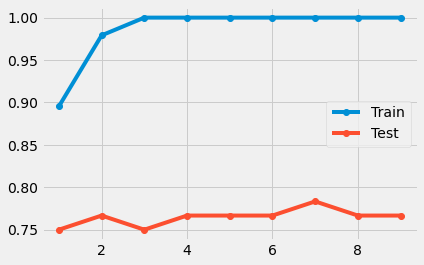

In [ ]:
import matplotlib.pyplot as plt
#define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 10)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model =XGBClassifier(max_depth=i)
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

En rajoutant les features segments notre accuracy à diminuer 

Text(82.34, 0.5, 'predicted label')

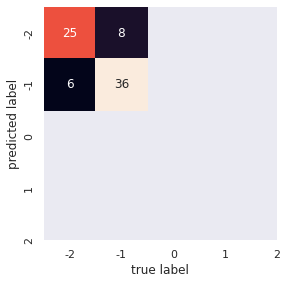

In [ ]:
sns.set()
mat = confusion_matrix(test_labels, predict_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=Classes, yticklabels=Classes)
plt.xlabel('true label')
plt.ylabel('predicted label')